<a href="https://colab.research.google.com/github/manmeet3/Deep_Learning2/blob/master/Asg4/meta-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Meta Learning
Using Omni glot dataset

In [28]:
# ref: https://github.com/shashankhalo7/Omniglot_meta_learning/blob/master/osl.ipynb

In [1]:
!wget https://github.com/manmeet3/Deep_Learning2/raw/master/Asg4/images_background.zip

--2020-10-21 03:43:14--  https://github.com/manmeet3/Deep_Learning2/raw/master/Asg4/images_background.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/manmeet3/Deep_Learning2/master/Asg4/images_background.zip [following]
--2020-10-21 03:43:15--  https://raw.githubusercontent.com/manmeet3/Deep_Learning2/master/Asg4/images_background.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9464212 (9.0M) [application/zip]
Saving to: ‘images_background.zip’

images_background.z 100%[===================>]   9.03M  3.33MB/s    in 2.7s    

2020-10-21 03:43:18 (3.33 MB/s) - ‘images_background.zip’ saved [9464212/9464212]



In [2]:
!wget https://github.com/manmeet3/Deep_Learning2/raw/master/Asg4/images_evaluation.zip

--2020-10-21 03:43:18--  https://github.com/manmeet3/Deep_Learning2/raw/master/Asg4/images_evaluation.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/manmeet3/Deep_Learning2/master/Asg4/images_evaluation.zip [following]
--2020-10-21 03:43:19--  https://raw.githubusercontent.com/manmeet3/Deep_Learning2/master/Asg4/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  3.41MB/s    in 1.8s    

2020-10-21 03:43:21 (3.41 MB/s) - ‘images_evaluation.zip’ saved [6462886/6462886]



In [3]:
!unzip -q images_background.zip
!unzip -q images_evaluation.zip

In [4]:
!ls

Multi_Instance_Learning.ipynb	images_background.zip  oasis3
Semi-Supervised_Learning.ipynb	images_evaluation      rl_hwk3.ipynb
VGG-transferlearning.model	images_evaluation.zip  simclrv2_finetuning
dl2-asg4-meta-learning		meta-learning.ipynb
images_background		minst


In [1]:
import sys
import numpy as np
import pandas as pd
from imageio import imread # from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

In [3]:
import numpy.random as rng

In [7]:
!mkdir data

In [4]:
# Train contains 30 different languages with 20 instances of 
# each character within each language
train_folder = "images_background/"
# Alphabets for 20 languages
val_folder = "images_evaluation/"
save_path = "data/"

In [5]:
def loadimages(path, n=0):
  '''
  Parameters:
  string:path -> Path of train or test directory

  Return Value:
  tuple:(x, y, language_dictionary)
  '''
  X=[]
  y=[]
  cat_dict = {}
  lang_dict = {}
  curr_y = n

  for alphabet in os.listdir(path):
    print("loading alphabet: " + alphabet)
    lang_dict[alphabet] = [curr_y, None]
    alphabet_path = os.path.join(path, alphabet)
    # Set each letter as its own column
    for letter in os.listdir(alphabet_path):
      cat_dict[curr_y] = (alphabet, letter)
      category_images=[]
      letter_path = os.path.join(alphabet_path, letter)
      # read images in current category
      for filename in os.listdir(letter_path):
        image_path = os.path.join(letter_path, filename)
        image = imread(image_path)
        category_images.append(image)
        y.append(curr_y)
      try:
        X.append(np.stack(category_images))
      # edge case - last one
      except ValueError as e:
        print(e)
        print("error - category_images:", category_images)
      curr_y += 1
      lang_dict[alphabet][1] = curr_y - 1
  y = np.vstack(y)
  X = np.stack(X)
  return X,y,lang_dict

In [6]:
X, y, c = loadimages(train_folder)

loading alphabet: Tifinagh
loading alphabet: Sanskrit
loading alphabet: Japanese_(katakana)
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Korean
loading alphabet: N_Ko
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Futurama
loading alphabet: Early_Aramaic
loading alphabet: Balinese
loading alphabet: Armenian
loading alphabet: Burmese_(Myanmar)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Braille
loading alphabet: Greek
loading alphabet: Japanese_(hiragana)
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Bengali
loading alphabet: Cyrillic
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Tagalog
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Latin
loading alphabet: Gujarati
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Grantha
loading alphabet: Arcadian


In [9]:
with open(os.path.join(save_path, "train.pickle"), "wb") as f:
  pickle.dump((X,c ), f)

In [10]:
Xval, yval, cval = loadimages(val_folder)

loading alphabet: Angelic
loading alphabet: Glagolitic
loading alphabet: ULOG
loading alphabet: Atlantean
loading alphabet: Atemayar_Qelisayer
loading alphabet: Kannada
loading alphabet: Tibetan
loading alphabet: Malayalam
loading alphabet: Ge_ez
loading alphabet: Oriya
loading alphabet: Keble
loading alphabet: Tengwar
loading alphabet: Gurmukhi
loading alphabet: Avesta
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Sylheti
loading alphabet: Syriac_(Serto)
loading alphabet: Aurek-Besh
loading alphabet: Mongolian
loading alphabet: Manipuri


In [11]:
with open(os.path.join(save_path, "validate.pickle"), "wb") as f:
  pickle.dump((Xval, cval), f)

In [12]:
def initialize_weights(shape, dtype=None):
  '''
     Initialize CNN layer weights with mean as 0.0 and standard deviation 0f 0.01
  '''
  return np.random.normal(loc = 0.0, scale = 1e-2, size=shape)

In [13]:
def initialize_bias(shape, dtype=None):
  '''
  Initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
  '''
  return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [14]:
def get_siamese_model(input_shape):
  # Define the tensor for the two input images
  left_input = Input(input_shape)
  right_input = Input(input_shape)

  #Convolutional NN
  model = Sequential()
  model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
  model.add(MaxPooling2D())
  model.add(Conv2D(128, (7,7), activation='relu',
                    kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
  model.add(MaxPooling2D())
  model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
  model.add(MaxPooling2D())
  model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
  model.add(Flatten())
  model.add(Dense(4096, activation='sigmoid',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
  
  # Generate the encodings for the two images
  encoded_l = model(left_input)
  encoded_r = model(right_input)

  # Add a customized layer to compute the absolute difference between encodings
  l1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  l1_distance = l1_layer([encoded_l, encoded_r])

  # Add a dense layer with a sigmoid unit to generate similarity score
  prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(l1_distance)
  
  # Connect the inputs with outputs
  siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

  return siamese_net

In [15]:
model = get_siamese_model((105, 105, 1)) #105x105 is the dataset image size
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]      

In [16]:
optimizer = Adam(lr=0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [27]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
  (Xtrain, train_classes) = pickle.load(f)

print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Tifinagh', 'Sanskrit', 'Japanese_(katakana)', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Korean', 'N_Ko', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Futurama', 'Early_Aramaic', 'Balinese', 'Armenian', 'Burmese_(Myanmar)', 'Malay_(Jawi_-_Arabic)', 'Braille', 'Greek', 'Japanese_(hiragana)', 'Syriac_(Estrangelo)', 'Asomtavruli_(Georgian)', 'Bengali', 'Cyrillic', 'Alphabet_of_the_Magi', 'Tagalog', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Latin', 'Gujarati', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Grantha', 'Arcadian']


In [28]:
with open(os.path.join(save_path, "validate.pickle"), "rb") as f:
  (Xval, val_classes) = pickle.load(f)

print("Validation alphabets: \n")
print(list(val_classes.keys()))

Validation alphabets: 

['Angelic', 'Glagolitic', 'ULOG', 'Atlantean', 'Atemayar_Qelisayer', 'Kannada', 'Tibetan', 'Malayalam', 'Ge_ez', 'Oriya', 'Keble', 'Tengwar', 'Gurmukhi', 'Avesta', 'Old_Church_Slavonic_(Cyrillic)', 'Sylheti', 'Syriac_(Serto)', 'Aurek-Besh', 'Mongolian', 'Manipuri']


In [29]:
def get_batch(bach_size,s="train"):
  ''' Create batch of npairs, half same class, half different class'''
  if s == 'train':
    X = Xtrain
    categories = train_classes
  else:
    X = Xval
    categories = val_classes
  n_classes, n_examples, w, h = X.shape

  # randomly sample several classes to use in the batch
  categories = rng.choice(n_classes, size=(batch_size,), replace=False)

  # initialize 2 empty arrays for the input image batch
  pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]

  # initialize vector for the targets
  targets=np.zeros((batch_size,))

  # Set 2nd half of batch targets to 1
  targets[batch_size//2:] = 1
  for i in range(batch_size):
    category = categories[i]
    idx_1 = rng.randint(0, n_examples)
    pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
    idx_2 = rng.randint(0, n_examples)

    # pick images of same class for 1st half, different for 2nd half
    if i >= batch_size//2:
      category_2 = category
    else:
      # add a random number to the category modulo n classes to ensure 2nd image 
      # has a different category
      category_2 = (category + rng.randint(1, n_classes)) % n_classes
    pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 1)

  return pairs, targets

In [30]:
def generate(batch_size, s="train"):
  ''' A generator for batches so model.fit_generator can be used '''
  while True:
    pairs, targets = get_batch(batch_size, s)
    yield(pairs, targets)

In [31]:
def make_oneshot_task(N, s="val", language=None):
  ''' Create pairs of test image, support set for testing N way one-shot learning'''
  if s == "train":
    X = Xtrain
    categories = train_classes
  else:
    X = Xval
    categories = val_classes
  n_classes, n_examples, w, h = X.shape

  indices = rng.randint(0, n_examples, size=(N,))
  if language is not None: # select characters if language is defined
    low, high = categories[language]
    if N > high - low:
      raise ValueError("This lanaguage ({}) has less than {} letters".format(language, N))

    categories = rng.choice(range(low, high), size=(N,), replace=False)
  else:
    categories = rng.choice(range(n_classes), size=(N,), replace=False)
  true_category = categories[0]
  ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
  test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, 1)
  support_set = X[categories, indices, :, :]
  support_set[0,:,:] = X[true_category, ex2]
  support_set = support_set.reshape(N, w, h, 1)
  targets = np.zeros((N,))
  targets[0] = 1
  targets, test_image, support_set = shuffle(targets, test_image, support_set)
  pairs = [test_image, support_set]

  return pairs,targets


In [32]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
  ''' Test average N way oneshot learning accuracy of a siamese NN over k one shot tasks '''
  n_correct = 0
  if verbose:
    print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))

  for i in range(k):
    inputs, targets = make_oneshot_task(N,s)
    probs = model.predict(inputs)
    if np.argmax(probs) == np.argmax(targets):
      n_correct += 1
  percent_correct = (100.0 * n_correct / k)
  if verbose:
    print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
  return percent_correct

In [33]:

# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [20]:
!mkdir weights
model_path = 'saved_multi_ins_models/'

mkdir: cannot create directory ‘weights’: File exists


In [21]:
!mkdir saved_multi_ins_models

mkdir: cannot create directory ‘saved_multi_ins_models’: File exists


In [48]:
print("Start training process!")
print("----------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
  (inputs, targets) = get_batch(batch_size)
  loss = model.train_on_batch(inputs, targets)
  if i % evaluate_every == 0:
    print("\n ----------- \n")
    print("Time for {0} iterations: {1} mins".format(i, (time.time()- t_start)/60))
    print("Train_loss: {0}".format(loss))
    val_acc = test_oneshot(model, N_way, n_val, verbose=True)
    model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
    if val_acc >= best:
      print("Current best: {0}, previous best: {1}".format(val_acc, best))
      best=val_acc

Start training process!
----------------------------------

 ----------- 

Time for 200 iterations: 0.35077447493871056 mins
Train_loss: 2.4335107803344727
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 32.0% 20 way one-shot learning accuracy 

Current best: 32.0, previous best: -1

 ----------- 

Time for 400 iterations: 0.8631574869155884 mins
Train_loss: 1.8870232105255127
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 44.4% 20 way one-shot learning accuracy 

Current best: 44.4, previous best: 32.0

 ----------- 

Time for 600 iterations: 1.3701218843460083 mins
Train_loss: 1.4331501722335815
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 52.8% 20 way one-shot learning accuracy 

Current best: 52.8, previous best: 44.4

 ----------- 

Time for 800 iterations: 1.867884604136149 mins
Train_loss: 1.1986349821090698
Evaluating model on 250 random 20 way one-shot learning

Current best: 79.2, previous best: 78.4

 ----------- 

Time for 7000 iterations: 17.655191417535146 mins
Train_loss: 0.25619396567344666
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% 20 way one-shot learning accuracy 

Current best: 82.8, previous best: 79.2

 ----------- 

Time for 7200 iterations: 18.154824467500053 mins
Train_loss: 0.21655167639255524
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% 20 way one-shot learning accuracy 


 ----------- 

Time for 7400 iterations: 18.667293481032054 mins
Train_loss: 0.23921826481819153
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 73.2% 20 way one-shot learning accuracy 


 ----------- 

Time for 7600 iterations: 19.20851619640986 mins
Train_loss: 0.23292911052703857
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ----------- 

T

Got an average of 79.2% 20 way one-shot learning accuracy 


 ----------- 

Time for 14200 iterations: 35.21079922119777 mins
Train_loss: 0.15324418246746063
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ----------- 

Time for 14400 iterations: 35.692937131722765 mins
Train_loss: 0.16915829479694366
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% 20 way one-shot learning accuracy 


 ----------- 

Time for 14600 iterations: 36.17583020925522 mins
Train_loss: 0.18785080313682556
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% 20 way one-shot learning accuracy 


 ----------- 

Time for 14800 iterations: 36.656425666809085 mins
Train_loss: 0.17270207405090332
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.4% 20 way one-shot learning accuracy 


 ----------- 

Time for 15000 ite

In [22]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

In [23]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [24]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [25]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [34]:

val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 98.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  50.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average

In [35]:

with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

In [36]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [37]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [38]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

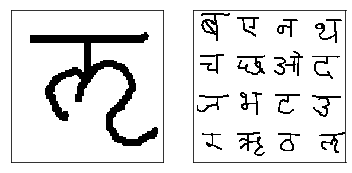

In [39]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

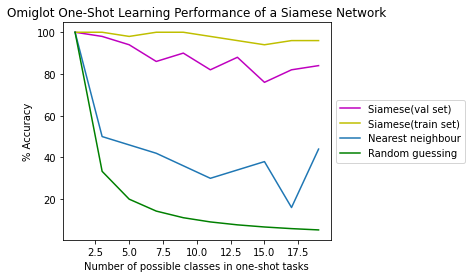

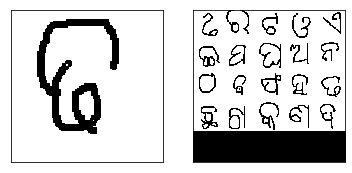

In [40]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)